In [ ]:
#hide
#all_slow

# Voxel-wise encoding models for BIDS datasets with naturalistic stimuli

> This BIDS App lets you train voxelwise-encoding models for continuous (naturalistic) stimuli provided as a BIDS-compliant continuous recording file.

![Tests](https://github.com/mjboos/voxelwiseencoding/workflows/CI/badge.svg)
[![License: MIT](https://img.shields.io/badge/License-MIT-yellow.svg)](https://opensource.org/licenses/MIT)

For more information about the specification of BIDS Apps see [here](https://docs.google.com/document/d/1E1Wi5ONvOVVnGhj21S1bmJJ4kyHFT7tkxnV3C23sjIE/).
For auditory stimuli [this](https://github.com/mjboos/audio2bidsstim/) module can help you convert your wav file to a BIDS stimulus representation.




## Install

If you are only interested in using the Python module for preprocessing fMRI, lagging the stimulus, and training encoding models without the BIDS app, you can install this library by running `python setup.py` or `pip install -e voxelwiseencoding`.
You can use the BIDS app either via Docker or directly by calling `run.py`.

## Description

This library allows you to train and validate voxel-wise encoding models for a BIDS dataset with a BIDS-compliant stimulus representation. See below for an example on how to use it.

### Example

We are going to use [this](https://openneuro.org/datasets/ds002322/versions/1.0.4) dataset to demonstrate an example workflow using the Python package.

First we need to download the data and extract a stimulus representation:


In [ ]:
#hide_output
!aws s3 sync --no-sign-request s3://openneuro.org/ds002322 /data/ds002322-download/
import json
# these are the parameters for extracting a Mel spectrogram
# for computational ease in this example we want 1 sec segments of 31 Mel frequencies with a max frequency of * KHz
mel_params = {'n_mels': 31, 'sr': 16000, 'hop_length': 16000, 'n_fft': 16000, 'fmax': 8000}
with open('config.json', 'w+') as fl:
    json.dump(mel_params, fl)

!git clone https://github.com/mjboos/audio2bidsstim/
!pip install -r audio2bidsstim/requirements.txt
!python audio2bidsstim/wav_files_to_bids_tsv.py /data/ds002322-download/stimuli/DownTheRabbitHoleFinal_mono_exp120_NR16_pad.wav -c config.json

download: s3://openneuro.org/ds002322/derivatives/sub-41/sub-41_task-alice_bold_preprocessed.nii.gz to ../../ds002322-download/derivatives/sub-41/sub-41_task-alice_bold_preprocessed.nii.gz
Cloning into 'audio2bidsstim'...
remote: Enumerating objects: 24, done.
remote: Counting objects: 100% (24/24), done.
remote: Compressing objects: 100% (15/15), done.
remote: Total 24 (delta 10), reused 21 (delta 7), pack-reused 0
Unpacking objects: 100% (24/24), done.


We then need to copy the extracted stimulus representation into the BIDS folder.

In [ ]:
!cp DownTheRabbitHoleFinal_mono_exp120_NR16_pad.tsv.gz /data/ds002322-download/derivatives/task-alice_stim.tsv.gz
!cp DownTheRabbitHoleFinal_mono_exp120_NR16_pad.json /data/ds002322-download/derivatives/sub-22/sub-22_task-alice_stim.json

And, lastly, because for this dataset the derivatives folder is missing timing information for the BOLD files - we are only interested in the TR - we have to copy that as well.

In [ ]:
!cp /data/ds002322-download/sub-22/sub-22_task-alice_bold.json /data/ds002322-download/derivatives/sub-22/sub-22_task-alice_bold.json 

We are now ready to define some model parameters and train the encoding model.

In [ ]:
from voxelwiseencoding.process_bids import run_model_for_subject

# these are the parameters used for preprocessing the BOLD fMRI files
bold_prep_params = {'standardize': 'zscore', 'detrend': True}

# and for lagging the stimulus as well - we want to include 6 sec stimulus segments to predict fMRI
lagging_params = {'lag_time': 6}

# these are the parameters for sklearn's Ridge estimator
ridge_params = {'alphas': [1e-1, 1, 100, 1000],
                'cv': 3, 'normalize': True}


ridges, scores, computed_mask = run_model_for_subject('22', '/data/ds002322-download/derivatives',
                                                      task='alice', mask='epi', bold_prep_kwargs=bold_prep_params,
                                                      preprocess_kwargs=lagging_params, encoding_kwargs=ridge_params)

We can now assess the quality out-of-sample prediction (in terms of product-moment correlations) of our models and visualize where we can predict well.

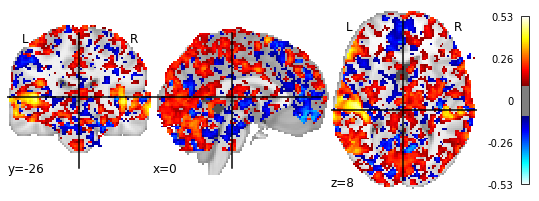

In [ ]:
from nilearn.masking import unmask
from nilearn.plotting import plot_stat_map
plot_stat_map(unmask(scores.mean(axis=-1), computed_mask), threshold=0.1)


## Documentation

[See here](https://mjboos.github.io/voxelwiseencoding) for further documentation about the Python package and consult the section "Using this module as a BIDS app" about how to use this library as a Docker image/BIDS app.

## How to report errors

If you encounter errors with this code or have any questions about its uage, please open an issue on the Github repository [here](https://github.com/mjboos/voxelwiseencoding/).
